In [54]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
from matplotlib.ticker import ScalarFormatter
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
from pyproj import Transformer
import scipy.stats as stats
import seaborn as sns
sns.set_style('ticks')
import numpy as np
import pandas as pd

%matplotlib inline

In [55]:
air_bnb = pd.read_csv('../data/AB_NYC_2019.csv')

In [56]:
air_bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [57]:
air_bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [58]:
air_bnb.isnull().any()

id                                False
name                               True
host_id                           False
host_name                          True
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                        True
reviews_per_month                  True
calculated_host_listings_count    False
availability_365                  False
dtype: bool

Right off the bat, I'm noticing that `last_review` is a string datatype, so it may be helpful to change that to a datetime object.

It also looks like the `price` column is price per evening, but there ia `minimum_nights` column that may be > 1, meaning that customer's will be spending more than the number indicated in the `price` column
* it may be helpful to create a `minimum_cost` column that multiplies price column by the minimum_nights column

I'm also noticing that some columns hav null values, but not very many. I'm not too concerned about dealing with those right now, but I'll need to formulate a plan on what to do with them.

In [59]:
air_bnb['minimum_cost'] = air_bnb['price'] * air_bnb['minimum_nights']

In [60]:
air_bnb['minimum_cost'].head()

0    149
1    225
2    450
3     89
4    800
Name: minimum_cost, dtype: int64

In [61]:
air_bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [62]:
air_bnb.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,minimum_cost
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,4.889500e+04
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327,1.284433e+03
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289,1.180456e+04
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000e+00
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,1.350000e+02
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,3.000000e+02
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,7.345000e+02
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,1.170000e+06


Let's get a feel for the distribution of the `minimum_cost` column:

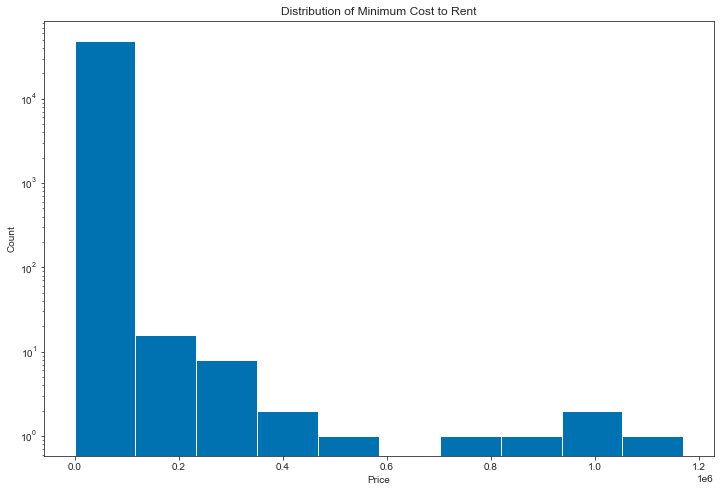

In [63]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(air_bnb['minimum_cost'], log=True)
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=True))
ax.set_title('Distribution of Minimum Cost to Rent')
ax.set_xlabel('Price')
ax.set_ylabel('Count');

Let's see what the distributions of listings is by borough

In [64]:
air_bnb['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

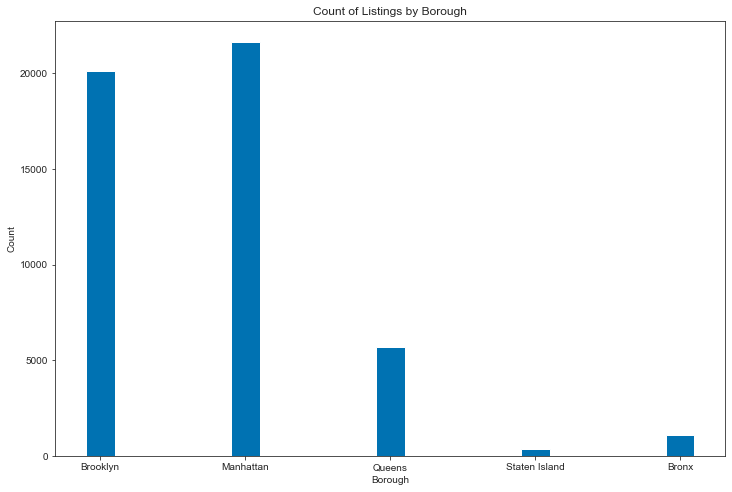

In [65]:
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(air_bnb['neighbourhood_group'], bins=np.arange(6)-0.5, rwidth=0.2)
ax.set_title('Count of Listings by Borough')
ax.set_xlabel('Borough')
ax.set_ylabel('Count');

In [66]:
# Let's take a look at how many unique neighborhood values there are

air_bnb['neighbourhood'].unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

In [67]:
# and the same for neighborhood group

air_bnb['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

Okay so `neighbourhood` is the actual neighborhood and `neighbourhood_group` is the burough.

In [68]:
# let's see if we can plot the longitude and latitude inforation on a map

BBox = (air_bnb['longitude'].min(), air_bnb['longitude'].max(),
        air_bnb['latitude'].min(), air_bnb['latitude'].max())

BBox

(-74.24441999999999, -73.71299, 40.499790000000004, 40.913059999999994)

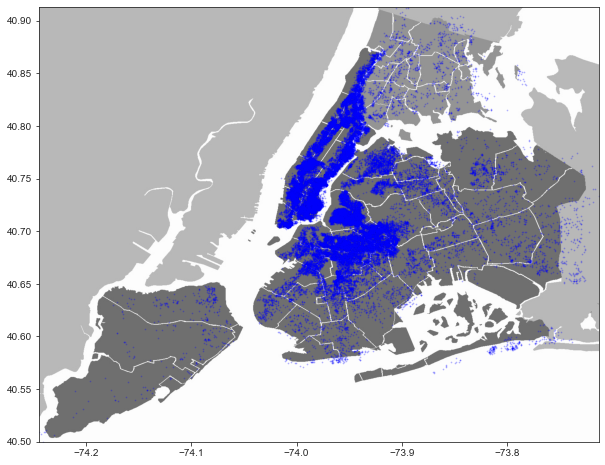

In [69]:
nyc_img = plt.imread('../images/New_York_City_.jpg')

fig, ax = plt.subplots(figsize=(12,8)) # 8,7
ax.scatter(air_bnb['longitude'], air_bnb['latitude'], zorder=1, alpha=0.2, c='b', s=.75)
ax.set_xlim(BBox[0], BBox[1])
ax.set_ylim(BBox[2], BBox[3])
ax.imshow(nyc_img, zorder=0, extent=BBox, aspect='equal')
fig.savefig('concentrationofbnblistingsnyc.jpg');

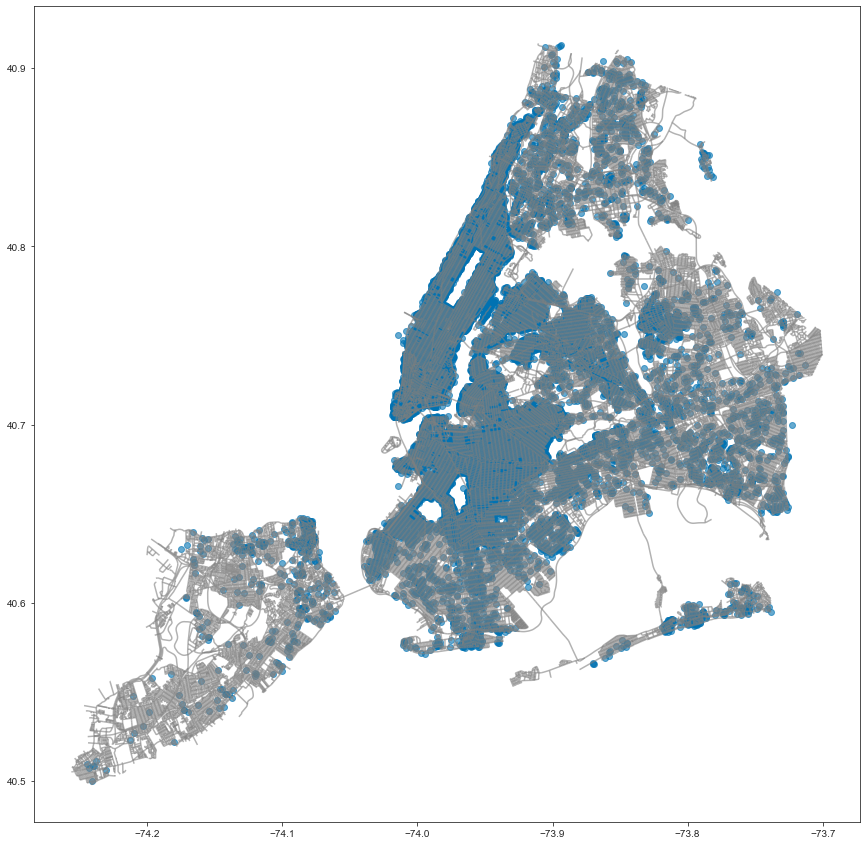

In [70]:
crs = 'EPSG:4326'

geometry = gpd.points_from_xy(air_bnb['longitude'], air_bnb['latitude'])

geometry[:3]

geo_df = gpd.GeoDataFrame(air_bnb, crs=crs, geometry=geometry)

nyc_map = gpd.read_file('../images/DCM_StreetCenterLine/geo_export_a62f9ef7-5ae2-49e1-9d3c-98a4f739efb9.shp')

fig, ax = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax, alpha=0.6, color='grey')
geo_df.plot(ax=ax, alpha=0.6);

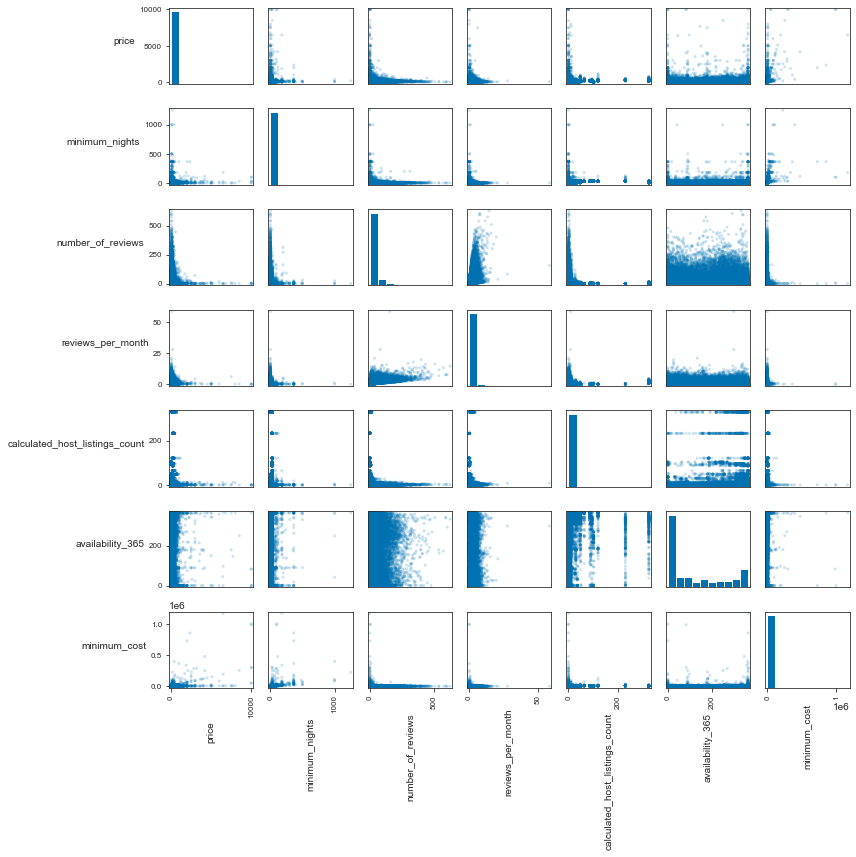

In [71]:
'''
Putting together a scatter matrix to determine if there are
relationships between certain variables
'''


columns = air_bnb[['neighbourhood_group', 'neighbourhood', 
                  'room_type', 'price', 'minimum_nights',
                  'number_of_reviews', 'reviews_per_month',
                   'calculated_host_listings_count',
                  'availability_365', 'minimum_cost']]

axes = pd.plotting.scatter_matrix(columns, figsize=(12,12), alpha=0.2,
                          diagonal='hist')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
plt.tight_layout();

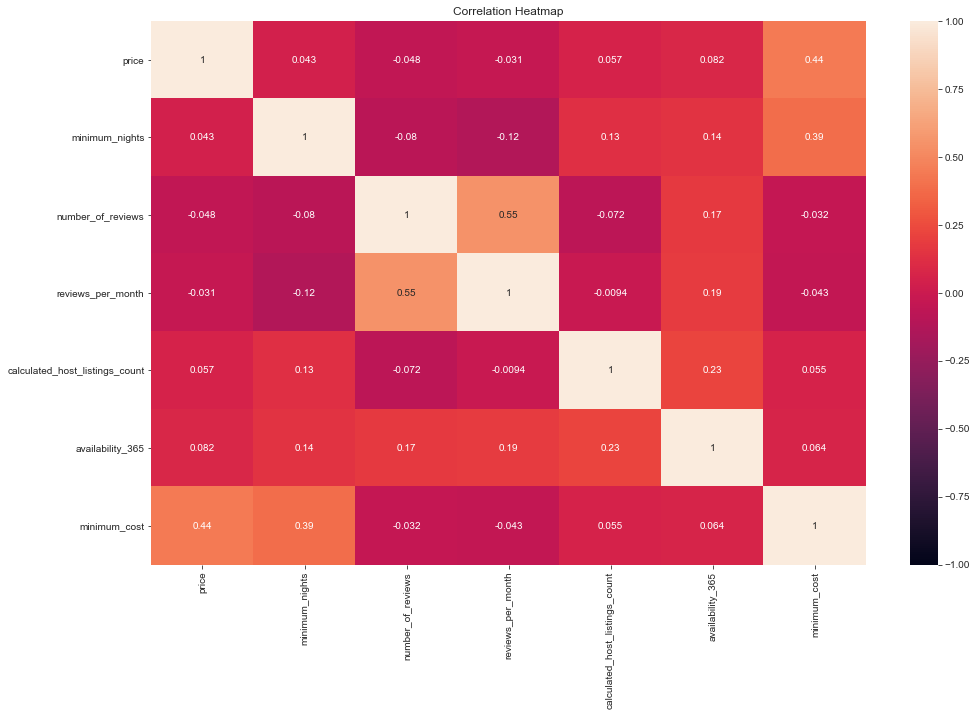

In [72]:
plt.figure(figsize=(16,10))

heatmap = sns.heatmap(columns.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap');

Coefficients above that are noteworthy:
* `calculated_host_listings_count` and `minimum_nights` = 0.13
* `calculated_host_listings_count` and `availability_365` = 0.23

Let's take a look at some additional visualizations:
* Distribution of prices across neighborhood/borough
* Distributions of minimum nights across neighborhood/borough
* Distribution of reviews across neighborhood/borough
* Amount of listings per host across neighborhood/borough

In [73]:
'''above we saw how many neighborhoods there are.
Maybe I can organize them by borough to make investigating them
a bit more manageable'''


grouped_by_borough_and_neighborhood = air_bnb.groupby(['neighbourhood_group', 'neighbourhood'], as_index=False)

In [74]:
for group in grouped_by_borough_and_neighborhood:
    print(group[:1])

(('Bronx', 'Allerton'),)
(('Bronx', 'Baychester'),)
(('Bronx', 'Belmont'),)
(('Bronx', 'Bronxdale'),)
(('Bronx', 'Castle Hill'),)
(('Bronx', 'City Island'),)
(('Bronx', 'Claremont Village'),)
(('Bronx', 'Clason Point'),)
(('Bronx', 'Co-op City'),)
(('Bronx', 'Concourse'),)
(('Bronx', 'Concourse Village'),)
(('Bronx', 'East Morrisania'),)
(('Bronx', 'Eastchester'),)
(('Bronx', 'Edenwald'),)
(('Bronx', 'Fieldston'),)
(('Bronx', 'Fordham'),)
(('Bronx', 'Highbridge'),)
(('Bronx', 'Hunts Point'),)
(('Bronx', 'Kingsbridge'),)
(('Bronx', 'Longwood'),)
(('Bronx', 'Melrose'),)
(('Bronx', 'Morris Heights'),)
(('Bronx', 'Morris Park'),)
(('Bronx', 'Morrisania'),)
(('Bronx', 'Mott Haven'),)
(('Bronx', 'Mount Eden'),)
(('Bronx', 'Mount Hope'),)
(('Bronx', 'North Riverdale'),)
(('Bronx', 'Norwood'),)
(('Bronx', 'Olinville'),)
(('Bronx', 'Parkchester'),)
(('Bronx', 'Pelham Bay'),)
(('Bronx', 'Pelham Gardens'),)
(('Bronx', 'Port Morris'),)
(('Bronx', 'Riverdale'),)
(('Bronx', 'Schuylerville'),)
(('Bro

## Boroughs/Neighborhoods to look at:
----------------------------------------------------
### Bronx:
* `Fordham`
* `Hunts Point`
* `Pelham Bay`
* `Riverdale`
* `Throgs Neck`
----------------------------------------------------

### Brooklyn:
* `Bay Ridge`
* `Bedford-Stuyvesant`
* `Bushwick`
* `Crown Heights`
* `Williamsburg`
-----------------------------------------------------
### Manhattan:
* `Chelsea`
* `East Village`
* `Greenwich Village`
* `Harlem`
* `SoHo`
------------------------------------------------------
### Queens:
* `Astoria`
* `Flushing`
* `Forest Hills`
* `Long Island City`
* `Ridgewood`
-----------------------------------------------------
### Staten Island:
* `Great Kills`
* `New Dorp`
* `St. George`
* `Tottenville`
* `West Brighton`

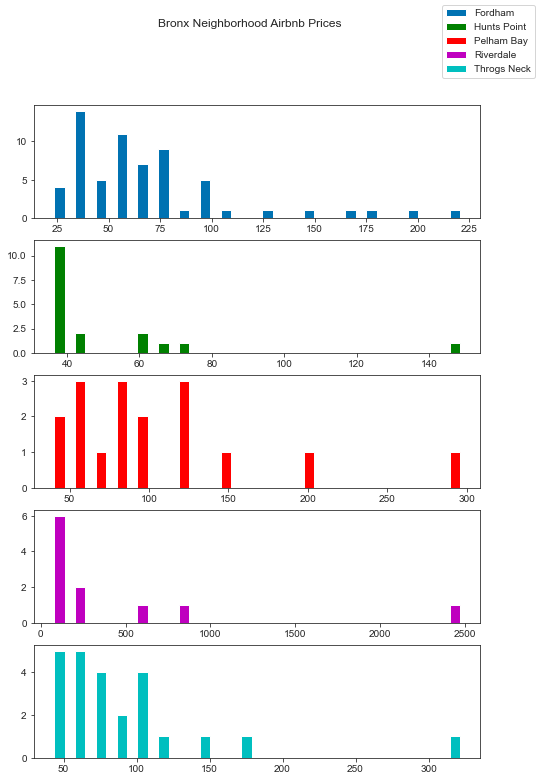

In [75]:
fordham = air_bnb[air_bnb['neighbourhood']=='Fordham']
hunts_point = air_bnb[air_bnb['neighbourhood']=='Hunts Point']
pelham_bay = air_bnb[air_bnb['neighbourhood']=='Pelham Bay']
riverdale = air_bnb[air_bnb['neighbourhood']=='Riverdale']
throgs_neck = air_bnb[air_bnb['neighbourhood']=='Throgs Neck']

to_plot = [fordham, hunts_point, pelham_bay, riverdale, throgs_neck]


fig, axs = plt.subplots(5, figsize=(8,12))
ax0, ax1, ax2, ax3, ax4 = axs.flatten()

ax0.hist(fordham['price'], bins=20, label = 'Fordham', rwidth=0.5)
ax1.hist(hunts_point['price'], bins=20, label = 'Hunts Point', color='g', rwidth=0.5)
ax2.hist(pelham_bay['price'], bins=20, label = 'Pelham Bay', color='r', rwidth=0.5)
ax3.hist(riverdale['price'], bins=20, label = 'Riverdale', color='m', rwidth=0.5)
ax4.hist(throgs_neck['price'], bins=20, label = 'Throgs Neck', color='c', rwidth=0.5)
fig.suptitle('Bronx Neighborhood Airbnb Prices')
fig.legend();

## Hypothesis Testing:
* Take a look at differences in pricing between boroughs
* Take a look at differences in pricing between hosts who have one listing vs multiple listings
* See if certain neighborhoods have higher availability/amount of listings per host

In [76]:
# let's take a look at the prices by borough

gb_neighborhood_grp = air_bnb.groupby('neighbourhood_group')['price'].value_counts()
gb_neighborhood_grp

neighbourhood_group  price
Bronx                60       60
                     50       58
                     40       50
                     75       50
                     80       45
                              ..
Staten Island        700       1
                     800       1
                     1000      1
                     1250      1
                     5000      1
Name: price, Length: 1542, dtype: int64

In [77]:
'''getting rid of the geometry column, which will
cause problems with removing outliers below'''

air_bnb.drop('geometry', axis=1, inplace=True)

In [78]:
# Dataframes for each borough

bronx = air_bnb[air_bnb['neighbourhood_group']=='Bronx']
brooklyn = air_bnb[air_bnb['neighbourhood_group']=='Brooklyn']
manhattan = air_bnb[air_bnb['neighbourhood_group']=='Manhattan']
staten = air_bnb[air_bnb['neighbourhood_group']=='Staten Island']
queens = air_bnb[air_bnb['neighbourhood_group']=='Queens']

Null-Hypothesis1: Bronx rental prices = Brooklyn rental prices
Alt-Hypothesis1: Bronx rental prices != Brooklyn rental prices
Alpha = 0.05

In [79]:
np.var(bronx['price']) == np.var(brooklyn['price'])

False

In [80]:
'''We see that the variances of prices in The Bronx and Brooklyn
are not the same... so we can perform a t-test'''

stat, p_val = stats.ttest_ind(bronx['price'], brooklyn['price'], equal_var=False)
print(f'The statistic is: {stat}\nThe P-value is: {p_val}')

The statistic is: -10.571750941203474
The P-value is: 3.112780095200205e-25


* It appears there is a very large statistical difference between rental prices in the Bronx and Brooklyn: 0.0000000000000000000000003112780095200205
- This is far below our alpha of 0.05

* Let's see if there is a statistical difference in rental prices between Brooklyn and Manhattan

Null-Hypothesis2: Brooklyn rental prices = Manhattan rental prices 
Alt-Hypothesis1: Brooklyn rental prices != Manhattan rental prices Alpha = 0.05

In [81]:
np.var(brooklyn['price']) == np.var(manhattan['price'])

False

In [82]:
stat, p_val = stats.ttest_ind(brooklyn['price'], manhattan['price'], equal_var=False)
print(f'The statistic is: {stat}\nThe P-value is: {p_val}')

The statistic is: -30.47971595131257
The P-value is: 1.4649940716903273e-201


It appears there is a very large statistical difference between rental prices in the Brooklyn and Manhattan: 1.4649940716903273e-201
This is far below our alpha of 0.05

These statistical results are looking pretty wild... I'm thinking it's time to look at some violin-plots and remove some potential outliers...

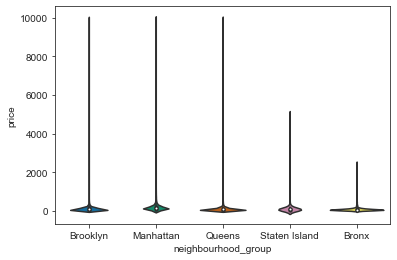

In [83]:
ax = sns.violinplot(x=air_bnb['neighbourhood_group'], y=air_bnb['price'], orient='v', figsize=(10,20));

* Okay so there are definitely some outliers... let's get rid of those and try doing some more hypothesis testing

In [84]:
# Helper Function
def remove_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    return df[~((df < (q1 - 1.5*iqr)) |
             (df > (q3 + 1.5*iqr))).any(axis=1)]

airbnb_nooutliers = remove_outliers(air_bnb)
brooklyn_nooutliers = remove_outliers(brooklyn)
bronx_nooutliers = remove_outliers(bronx)
manhattan_nooutliers = remove_outliers(manhattan)
queens_nooutliers = remove_outliers(queens)
staten_nooutliers = remove_outliers(staten)

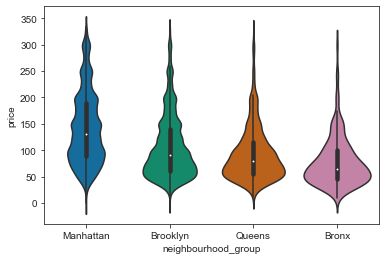

In [95]:
ax = sns.violinplot(x=airbnb_nooutliers['neighbourhood_group'], y=airbnb_nooutliers['price'], orient='v', figsize=(10,30));

Let's make a violin plot for prices of each borough to make sure the function worked on everything:

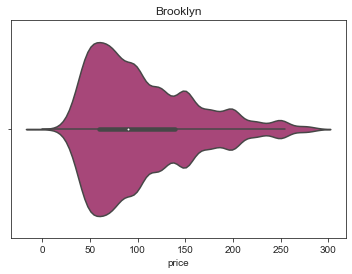

In [86]:
ax = sns.violinplot(x=brooklyn_nooutliers['price'], palette='magma').set_title('Brooklyn')

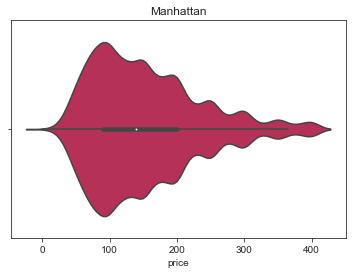

In [87]:
ax = sns.violinplot(x=manhattan_nooutliers['price'], palette='rocket').set_title('Manhattan')

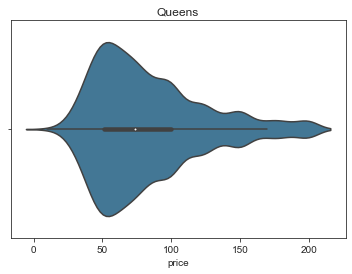

In [88]:
ax = sns.violinplot(x=queens_nooutliers['price'], palette='mako').set_title('Queens')

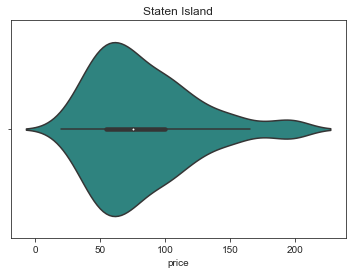

In [89]:
ax = sns.violinplot(x=staten_nooutliers['price'], palette='viridis').set_title('Staten Island')

Okay.... now it's time to retry those hypothesis tests:

* Null-Hypothesis1: Bronx rental prices = Brooklyn rental prices 
* Alt-Hypothesis1: Bronx rental prices != Brooklyn rental prices 
* Alpha = 0.05

In [90]:
np.var(bronx_nooutliers['price']) == np.var(brooklyn_nooutliers['price'])

False

In [91]:
stat, p_val = stats.ttest_ind(bronx_nooutliers['price'], brooklyn_nooutliers['price'], equal_var=False)
print(f'The statistic is: {stat}\nThe P-value is: {p_val}')

The statistic is: -22.928618135457267
The P-value is: 3.372692554424379e-92


Okay so the results are still quite significant, which means Bronx and Brooklyn rental prices are not the same

* now let's try it with the rest of the boroughs

* Null-Hypothesis2: Brooklyn rental prices = Manhattan rental prices * Alt-Hypothesis1: Brooklyn rental prices != Manhattan rental prices * Alpha = 0.05

In [92]:
stat, p_val = stats.ttest_ind(brooklyn_nooutliers['price'], manhattan_nooutliers['price'], equal_var=False)
print(f'The statistic is: {stat}\nThe P-value is: {p_val}')

The statistic is: -54.277389156640076
The P-value is: 0.0


Same deal... the p-value is essentially zero, which means that the prices between brooklyn and manhattan rentals are not the same.

* We can reject the null hypothesis

* Null-Hypothesis3: Brooklyn rental prices = Queens rental prices 
* Alt-Hypothesis3: Brooklyn rental prices != Queens rental prices 
* Alpha = 0.05

In [93]:
stat, p_val = stats.ttest_ind(brooklyn_nooutliers['price'], queens_nooutliers['price'], equal_var=False)
print(f'The statistic is: {stat}\nThe P-value is: {p_val}')

The statistic is: 24.63607892282018
The P-value is: 2.532811850514098e-129


The p-value is VERY small, which means that the prices between Brooklyn and Queens rentals are not the same.

We can reject the null hypothesis.

In [94]:
air_bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     